In [2]:
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from setup.constants import PROJECT_ROOT
from pathlib import Path

In [3]:
wine_schema = {'free sulfur dioxide': pl.Float64, 'total sulfur dioxide': pl.Float64, 'quality': pl.Float64}

red_wine_df = pl.read_csv(
    PROJECT_ROOT / 'data' / 'winequality-red.csv', 
    separator=';',
    schema_overrides=wine_schema
)
print(red_wine_df.head(5))

white_wine_df = pl.read_csv(
    PROJECT_ROOT / 'data' / 'winequality-white.csv', 
    separator=';',
    schema_overrides=wine_schema    
)
print(white_wine_df.head(5))

shape: (5, 12)
┌─────────┬──────────┬─────────────┬────────────────┬───┬──────┬───────────┬─────────┬─────────┐
│ fixed   ┆ volatile ┆ citric acid ┆ residual sugar ┆ … ┆ pH   ┆ sulphates ┆ alcohol ┆ quality │
│ acidity ┆ acidity  ┆ ---         ┆ ---            ┆   ┆ ---  ┆ ---       ┆ ---     ┆ ---     │
│ ---     ┆ ---      ┆ f64         ┆ f64            ┆   ┆ f64  ┆ f64       ┆ f64     ┆ f64     │
│ f64     ┆ f64      ┆             ┆                ┆   ┆      ┆           ┆         ┆         │
╞═════════╪══════════╪═════════════╪════════════════╪═══╪══════╪═══════════╪═════════╪═════════╡
│ 7.4     ┆ 0.7      ┆ 0.0         ┆ 1.9            ┆ … ┆ 3.51 ┆ 0.56      ┆ 9.4     ┆ 5.0     │
│ 7.8     ┆ 0.88     ┆ 0.0         ┆ 2.6            ┆ … ┆ 3.2  ┆ 0.68      ┆ 9.8     ┆ 5.0     │
│ 7.8     ┆ 0.76     ┆ 0.04        ┆ 2.3            ┆ … ┆ 3.26 ┆ 0.65      ┆ 9.8     ┆ 5.0     │
│ 11.2    ┆ 0.28     ┆ 0.56        ┆ 1.9            ┆ … ┆ 3.16 ┆ 0.58      ┆ 9.8     ┆ 6.0     │
│ 7.4     ┆ 0.7

In [4]:
print(red_wine_df.null_count() == 0)
print(white_wine_df.null_count() == 0)

shape: (1, 12)
┌─────────┬──────────┬─────────────┬────────────────┬───┬──────┬───────────┬─────────┬─────────┐
│ fixed   ┆ volatile ┆ citric acid ┆ residual sugar ┆ … ┆ pH   ┆ sulphates ┆ alcohol ┆ quality │
│ acidity ┆ acidity  ┆ ---         ┆ ---            ┆   ┆ ---  ┆ ---       ┆ ---     ┆ ---     │
│ ---     ┆ ---      ┆ bool        ┆ bool           ┆   ┆ bool ┆ bool      ┆ bool    ┆ bool    │
│ bool    ┆ bool     ┆             ┆                ┆   ┆      ┆           ┆         ┆         │
╞═════════╪══════════╪═════════════╪════════════════╪═══╪══════╪═══════════╪═════════╪═════════╡
│ true    ┆ true     ┆ true        ┆ true           ┆ … ┆ true ┆ true      ┆ true    ┆ true    │
└─────────┴──────────┴─────────────┴────────────────┴───┴──────┴───────────┴─────────┴─────────┘
shape: (1, 12)
┌─────────┬──────────┬─────────────┬────────────────┬───┬──────┬───────────┬─────────┬─────────┐
│ fixed   ┆ volatile ┆ citric acid ┆ residual sugar ┆ … ┆ pH   ┆ sulphates ┆ alcohol ┆ quality │


In [5]:
red_wine_df.describe()

statistic,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""",1599.0,1599.0,1599.0,1599.0,1599.0,1599.0,1599.0,1599.0,1599.0,1599.0,1599.0,1599.0
"""null_count""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""mean""",8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
"""std""",1.741096,0.17906,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
"""min""",4.6,0.12,0.0,0.9,0.012,1.0,6.0,0.99007,2.74,0.33,8.4,3.0
"""25%""",7.1,0.39,0.09,1.9,0.07,7.0,22.0,0.9956,3.21,0.55,9.5,5.0
"""50%""",7.9,0.52,0.26,2.2,0.079,14.0,38.0,0.99675,3.31,0.62,10.2,6.0
"""75%""",9.2,0.64,0.42,2.6,0.09,21.0,62.0,0.99784,3.4,0.73,11.1,6.0
"""max""",15.9,1.58,1.0,15.5,0.611,72.0,289.0,1.00369,4.01,2.0,14.9,8.0


In [6]:
white_wine_df.describe()

statistic,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""",4898.0,4898.0,4898.0,4898.0,4898.0,4898.0,4898.0,4898.0,4898.0,4898.0,4898.0,4898.0
"""null_count""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""mean""",6.854788,0.278241,0.334192,6.391415,0.045772,35.308085,138.360657,0.994027,3.188267,0.489847,10.514267,5.877909
"""std""",0.843868,0.100795,0.12102,5.072058,0.021848,17.007137,42.498065,0.002991,0.151001,0.114126,1.230621,0.885639
"""min""",3.8,0.08,0.0,0.6,0.009,2.0,9.0,0.98711,2.72,0.22,8.0,3.0
"""25%""",6.3,0.21,0.27,1.7,0.036,23.0,108.0,0.99172,3.09,0.41,9.5,5.0
"""50%""",6.8,0.26,0.32,5.2,0.043,34.0,134.0,0.99374,3.18,0.47,10.4,6.0
"""75%""",7.3,0.32,0.39,9.9,0.05,46.0,167.0,0.9961,3.28,0.55,11.4,6.0
"""max""",14.2,1.1,1.66,65.8,0.346,289.0,440.0,1.03898,3.82,1.08,14.2,9.0


In [7]:
print(
    red_wine_df.group_by(
        pl.col('quality')
    )
    .agg(
        pl.len()
    )
    .sort(
        pl.col('quality'),
        descending=True
    )
)

shape: (6, 2)
┌─────────┬─────┐
│ quality ┆ len │
│ ---     ┆ --- │
│ f64     ┆ u32 │
╞═════════╪═════╡
│ 8.0     ┆ 18  │
│ 7.0     ┆ 199 │
│ 6.0     ┆ 638 │
│ 5.0     ┆ 681 │
│ 4.0     ┆ 53  │
│ 3.0     ┆ 10  │
└─────────┴─────┘


In [8]:
red_wine_df_qc = red_wine_df.with_columns(
        pl.when(pl.col('quality') >= 7)
        .then(pl.lit('good'))
        .when(pl.col('quality') >= 5)
        .then(pl.lit('average'))
        .otherwise(pl.lit('bad'))
        .alias('quality category')
)

print(red_wine_df_qc.group_by(
        pl.col('quality category'),
    )
    .agg(
        pl.len().alias('# of samples')
    )
    .sort(
        pl.col('# of samples'),
        descending=True
    )
)

shape: (3, 2)
┌──────────────────┬──────────────┐
│ quality category ┆ # of samples │
│ ---              ┆ ---          │
│ str              ┆ u32          │
╞══════════════════╪══════════════╡
│ average          ┆ 1319         │
│ good             ┆ 217          │
│ bad              ┆ 63           │
└──────────────────┴──────────────┘


In [9]:
print(
    white_wine_df.group_by(
        pl.col('quality')
    )
    .agg(
        pl.len()
    )
    .sort(
        pl.col('quality'),
        descending=True
    )
)

shape: (7, 2)
┌─────────┬──────┐
│ quality ┆ len  │
│ ---     ┆ ---  │
│ f64     ┆ u32  │
╞═════════╪══════╡
│ 9.0     ┆ 5    │
│ 8.0     ┆ 175  │
│ 7.0     ┆ 880  │
│ 6.0     ┆ 2198 │
│ 5.0     ┆ 1457 │
│ 4.0     ┆ 163  │
│ 3.0     ┆ 20   │
└─────────┴──────┘


In [10]:
white_wine_df_qc = white_wine_df.with_columns(
    pl.when(pl.col('quality') >= 7)
    .then(pl.lit('good'))
    .when(pl.col('quality') >= 5)
    .then(pl.lit('average'))
    .otherwise(pl.lit('bad'))
    .alias('quality category')
)
print(
    white_wine_df_qc.group_by(
        pl.col('quality category')
    )
    .agg(
        pl.len().alias('# of samples')
    )
    .sort(
        pl.col('# of samples'),
        descending=True
    )
)

shape: (3, 2)
┌──────────────────┬──────────────┐
│ quality category ┆ # of samples │
│ ---              ┆ ---          │
│ str              ┆ u32          │
╞══════════════════╪══════════════╡
│ average          ┆ 3655         │
│ good             ┆ 1060         │
│ bad              ┆ 183          │
└──────────────────┴──────────────┘


In [12]:
import os
for color in ['white', 'red']:
    if not os.path.isdir(PROJECT_ROOT / 'figures' / color):
        os.makedirs(PROJECT_ROOT / 'figures' / color)

In [15]:
columns = [col for col in red_wine_df.columns if col != 'target']
agg_exprs = [pl.col(col).mean().alias(f'{col}_mean') for col in columns]

red_wine_means_df = red_wine_df_qc.group_by(
    pl.col('quality category')
).agg(
    agg_exprs
).sort(
    pl.col('quality_mean'),
    descending=True
)
red_wine_means_df

quality category,fixed acidity_mean,volatile acidity_mean,citric acid_mean,residual sugar_mean,chlorides_mean,free sulfur dioxide_mean,total sulfur dioxide_mean,density_mean,pH_mean,sulphates_mean,alcohol_mean,quality_mean
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""good""",8.847005,0.40553,0.376498,2.708756,0.075912,13.981567,34.889401,0.99603,3.288802,0.743456,11.518049,7.082949
"""average""",8.254284,0.53856,0.258264,2.503867,0.088973,16.368461,48.946929,0.996867,3.311296,0.647263,10.252717,5.4837
"""bad""",7.871429,0.724206,0.173651,2.684921,0.09573,12.063492,34.444444,0.996689,3.384127,0.592222,10.215873,3.84127


In [16]:
white_wine_means_df = white_wine_df_qc.group_by(
    'quality category'
).agg(
    agg_exprs
).sort(
    pl.col('quality_mean'),
    descending=True
)
white_wine_means_df

quality category,fixed acidity_mean,volatile acidity_mean,citric acid_mean,residual sugar_mean,chlorides_mean,free sulfur dioxide_mean,total sulfur dioxide_mean,density_mean,pH_mean,sulphates_mean,alcohol_mean,quality_mean
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""good""",6.725142,0.265349,0.326057,5.261509,0.03816,34.550472,125.245283,0.992412,3.215132,0.500142,11.416022,7.174528
"""average""",6.87606,0.277086,0.337877,6.797729,0.04774,35.962107,142.571272,0.99448,3.18072,0.487557,10.269808,5.601368
"""bad""",7.180874,0.375984,0.307705,4.821038,0.050557,26.63388,130.23224,0.994343,3.183388,0.475956,10.173497,3.89071


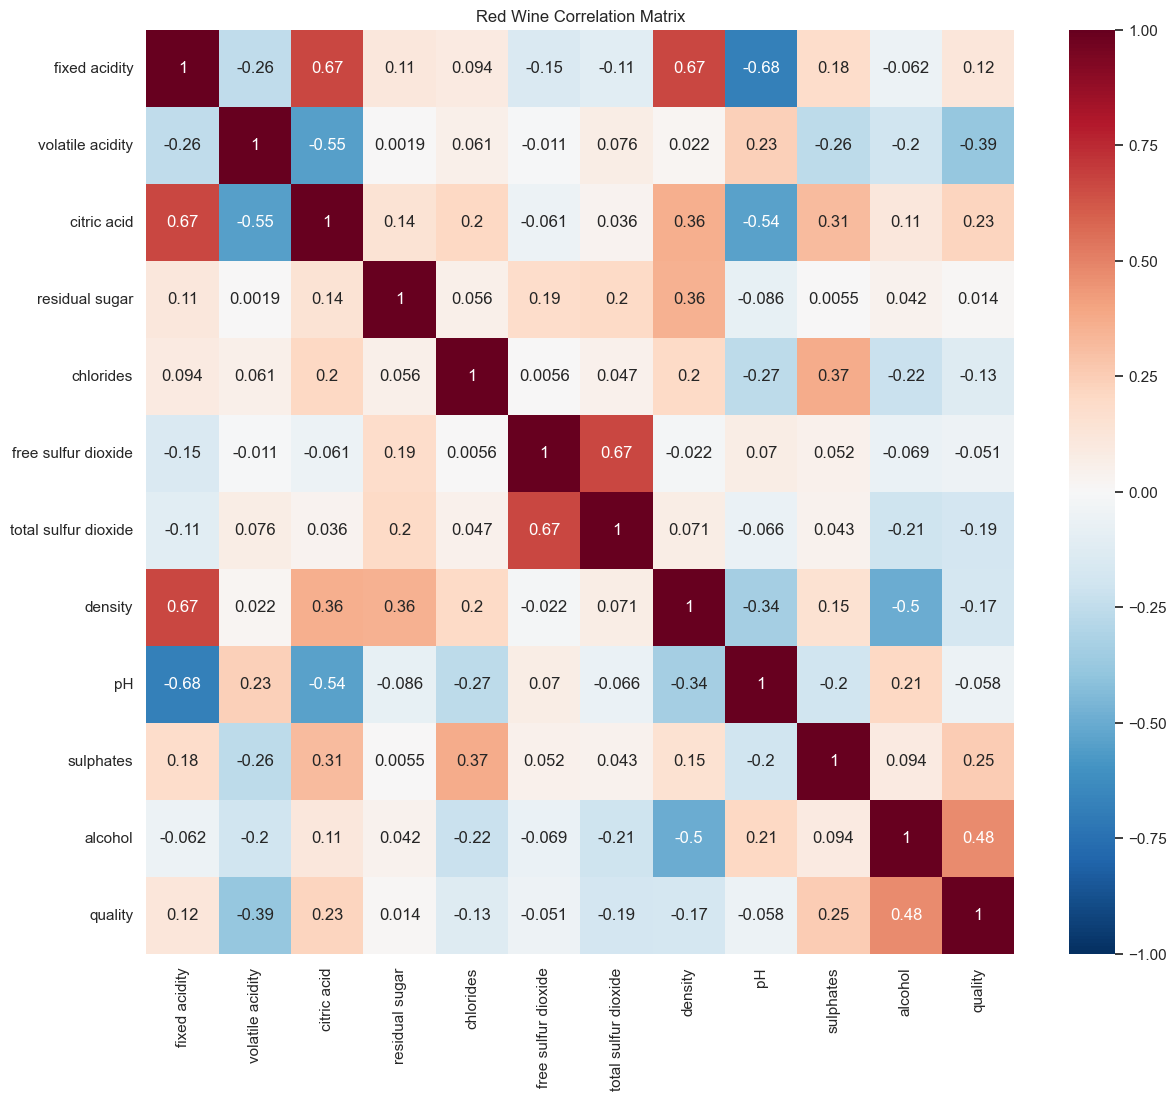

In [86]:
red_wine_corr = red_wine_df.corr()
plt.figure(figsize=(14, 12))
heatmap = sns.heatmap(red_wine_corr, annot=True, linewidths=0, vmin=-1, cmap='RdBu_r', xticklabels=red_wine_df.columns, yticklabels=red_wine_df.columns)
plt.title('Red Wine Correlation Matrix')
plt.savefig(PROJECT_ROOT / 'figures' / 'red' / 'correlation_matrix')


In [80]:
def make_scatter_hist(
        df:pl.DataFrame,
        x:str,
        y:str,
        filename:Path,
        title:str
) -> None:
    plt.figure()
    gridA = (sns.JointGrid(
        x=x,
        y=y,
        data=df
    )
    .plot_joint(sns.regplot, scatter_kws={'s':10})
    .plot_marginals(sns.histplot)
    )
    plt.title(title)
    gridA.savefig(filename)


<Figure size 640x480 with 0 Axes>

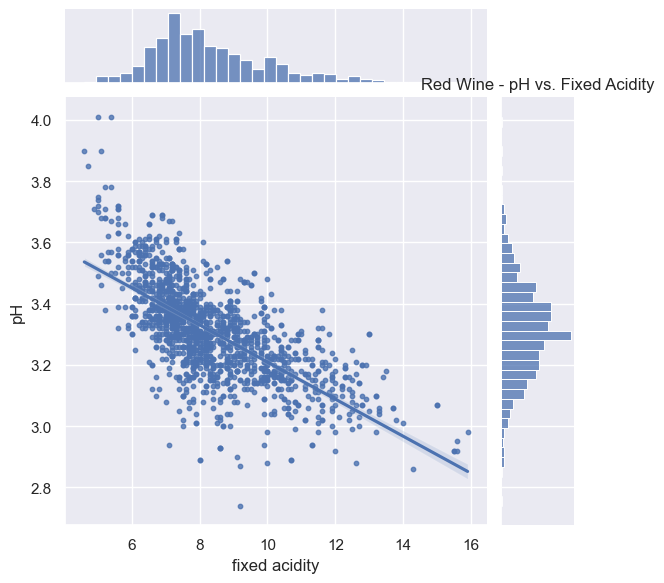

In [81]:
make_scatter_hist(
    df=red_wine_df[['fixed acidity', 'pH']], 
    x='fixed acidity', 
    y='pH', 
    filename=PROJECT_ROOT / 'figures' / 'red' / 'fixedAcidity_pH',
    title='Red Wine - pH vs. Fixed Acidity'    
)

<Figure size 640x480 with 0 Axes>

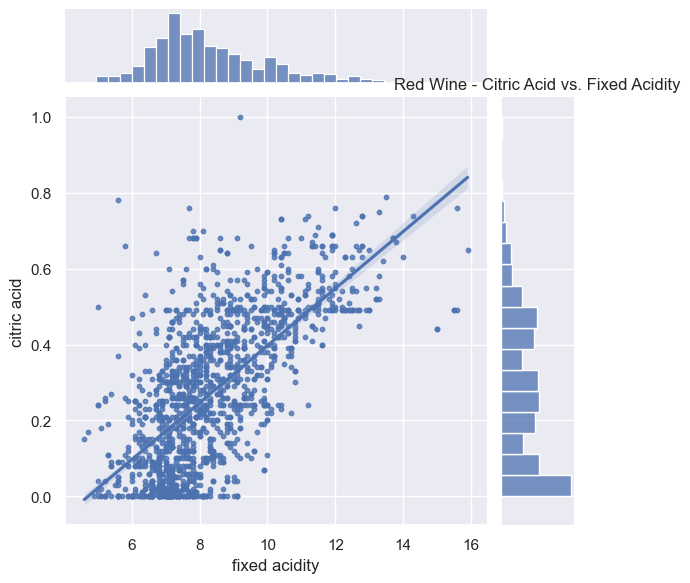

In [83]:
make_scatter_hist(
    df=red_wine_df[['fixed acidity', 'citric acid']], 
    x='fixed acidity', 
    y='citric acid', 
    filename=PROJECT_ROOT / 'figures' / 'red' / 'fixedAcidity_citricAcid',
    title='Red Wine - Citric Acid vs. Fixed Acidity'    
)

<Figure size 640x480 with 0 Axes>

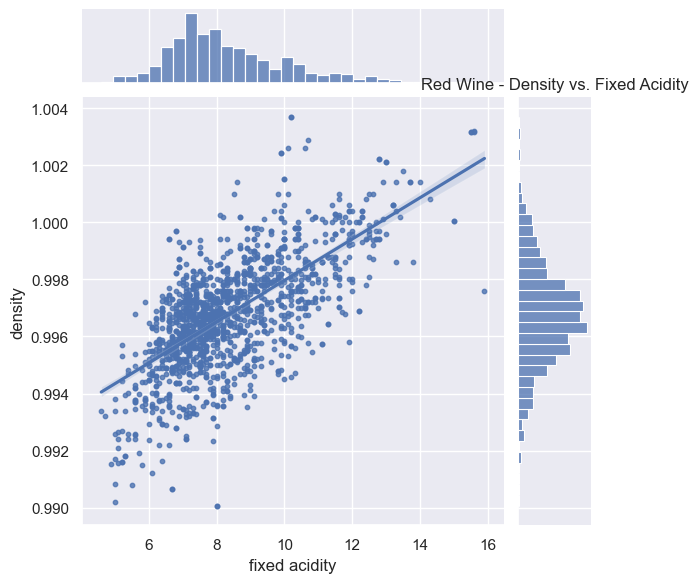

In [84]:
make_scatter_hist(
    df=red_wine_df[['fixed acidity', 'density']], 
    x='fixed acidity', 
    y='density', 
    filename=PROJECT_ROOT / 'figures' / 'red' / 'fixedAcidity_density',
    title='Red Wine - Density vs. Fixed Acidity'    
)

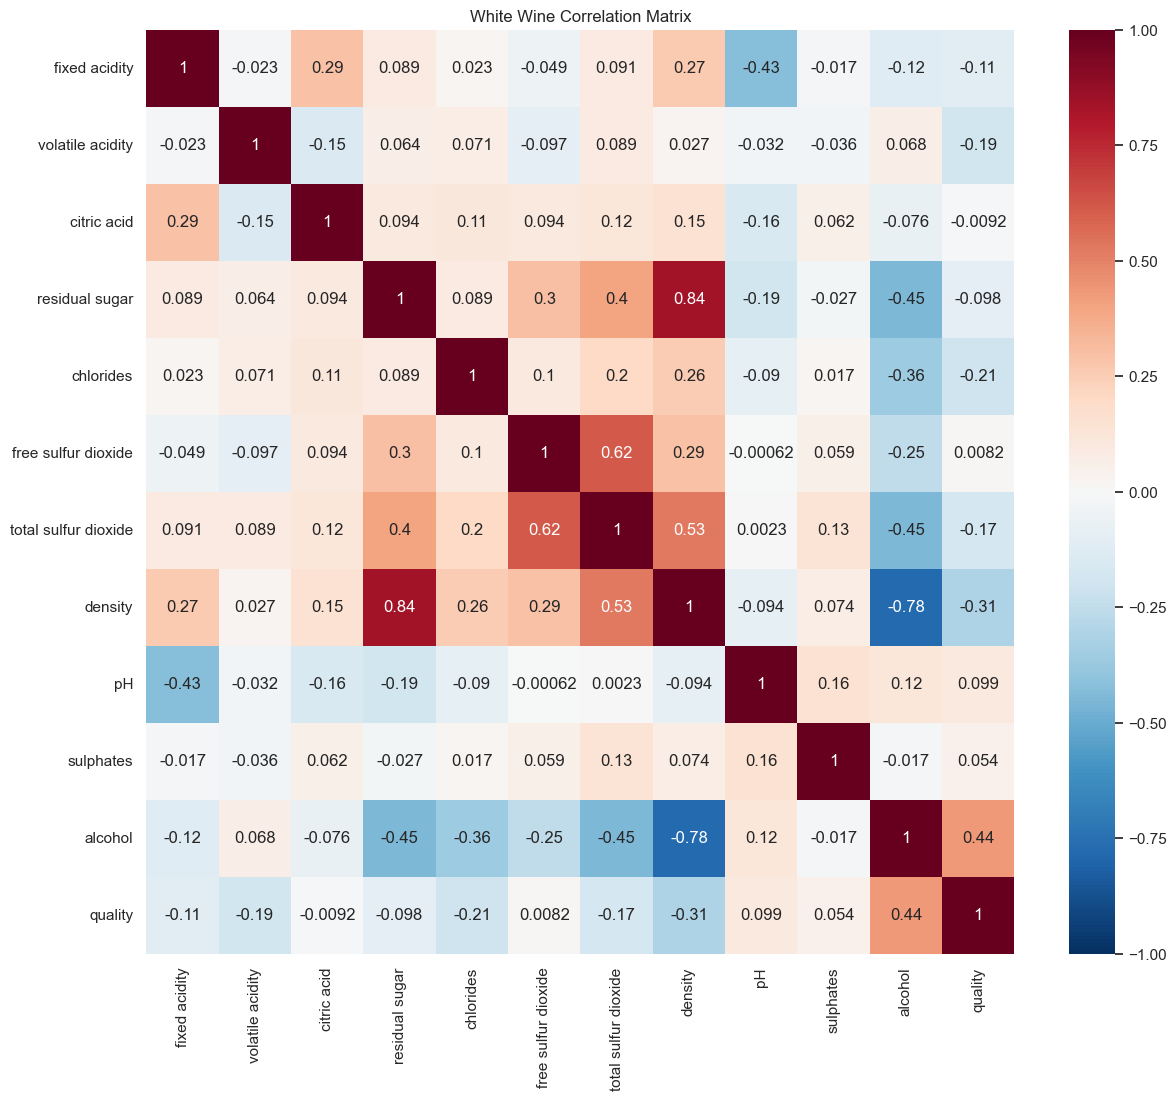

In [88]:
white_wine_corr = white_wine_df.corr()
plt.figure(figsize=(14, 12))
heatmap = sns.heatmap(white_wine_corr, annot=True, linewidths=0, vmin=-1, cmap='RdBu_r', xticklabels=white_wine_df.columns, yticklabels=white_wine_df.columns)
plt.title('White Wine Correlation Matrix')
plt.savefig(PROJECT_ROOT / 'figures' / 'white' / 'correlation_matrix')


<Figure size 640x480 with 0 Axes>

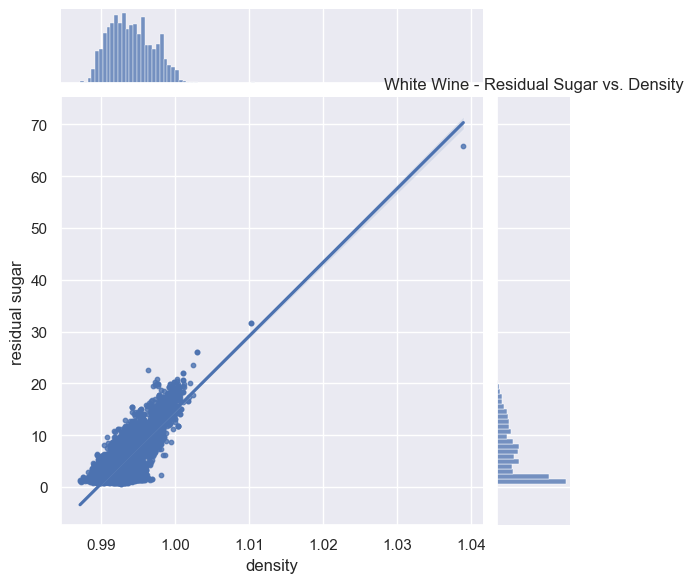

In [89]:
make_scatter_hist(
    df=white_wine_df[['density', 'residual sugar']], 
    x='density', 
    y='residual sugar', 
    filename=PROJECT_ROOT / 'figures' / 'white' / 'density_residualSugar',
    title='White Wine - Residual Sugar vs. Density'
)

<Figure size 640x480 with 0 Axes>

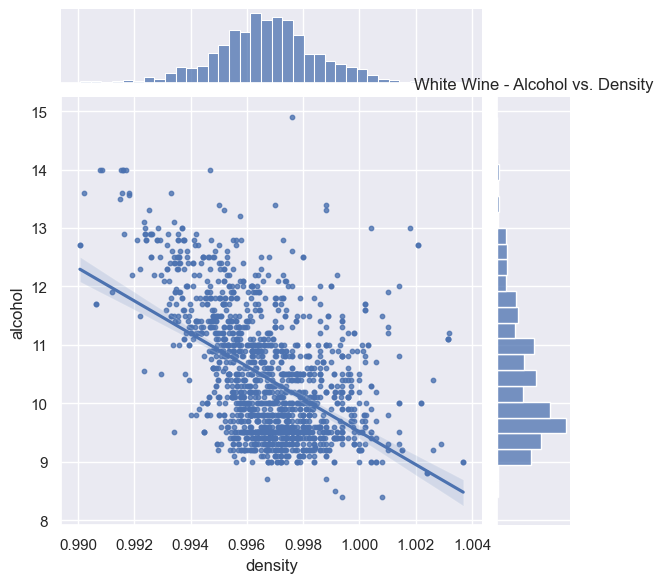

In [90]:
make_scatter_hist(
    df=red_wine_df[['density', 'alcohol']], 
    x='density', 
    y='alcohol', 
    filename=PROJECT_ROOT / 'figures' / 'white' / 'density_alcohol',
    title='White Wine - Alcohol vs. Density'
)

In [64]:
red_va_by_quality = red_wine_df.group_by(
    pl.col('quality')
).agg(
    pl.col('volatile acidity').mean().name.suffix(' mean')
).sort(
    pl.col('quality'),
    descending=True
)
print(red_va_by_quality)

white_va_by_quality = white_wine_df.group_by(
    pl.col('quality')
).agg(
    pl.col('volatile acidity').mean().name.suffix(' mean')
).sort(
    pl.col('quality'),
    descending=True
)
print(white_va_by_quality)

shape: (6, 2)
┌─────────┬───────────────────────┐
│ quality ┆ volatile acidity mean │
│ ---     ┆ ---                   │
│ f64     ┆ f64                   │
╞═════════╪═══════════════════════╡
│ 8.0     ┆ 0.423333              │
│ 7.0     ┆ 0.40392               │
│ 6.0     ┆ 0.497484              │
│ 5.0     ┆ 0.577041              │
│ 4.0     ┆ 0.693962              │
│ 3.0     ┆ 0.8845                │
└─────────┴───────────────────────┘
shape: (7, 2)
┌─────────┬───────────────────────┐
│ quality ┆ volatile acidity mean │
│ ---     ┆ ---                   │
│ f64     ┆ f64                   │
╞═════════╪═══════════════════════╡
│ 9.0     ┆ 0.298                 │
│ 8.0     ┆ 0.2774                │
│ 7.0     ┆ 0.262767              │
│ 6.0     ┆ 0.260564              │
│ 5.0     ┆ 0.302011              │
│ 4.0     ┆ 0.381227              │
│ 3.0     ┆ 0.33325               │
└─────────┴───────────────────────┘


In [98]:
colors = {np.float64(3.0):'#FF9800', np.float64(4.0):'#FFC107', np.float64(5.0):'#FFEB3B', np.float64(6.0):'#DCE775', np.float64(7.0):'#AEEA00', np.float64(8.0):'#64DD17', np.float64(9.0):'#00C853'}
def make_barplot(
        df:pl.DataFrame,
        x:str,
        y:str,
        title:str,
        filename:Path,
        hue:str = 'quality',
        palette:dict = colors,
) -> None:
    plt.figure(figsize=((12,6)))
    sns.barplot(
        data=df,
        x=x,
        y=y,
        hue=hue,
        palette=palette
    )
    plt.title(title)
    plt.savefig(filename)

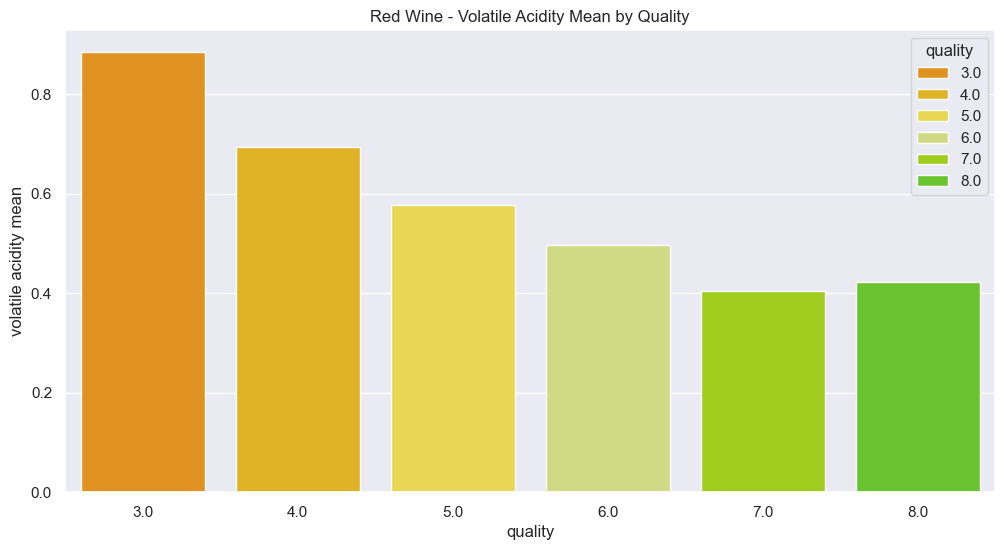

In [99]:
make_barplot(
    df=red_va_by_quality,
    x='quality',
    y='volatile acidity mean',
    title='Red Wine - Volatile Acidity Mean by Quality',
    filename=PROJECT_ROOT / 'figures' / 'red' / 'volatile_acid_mean_quality'
)

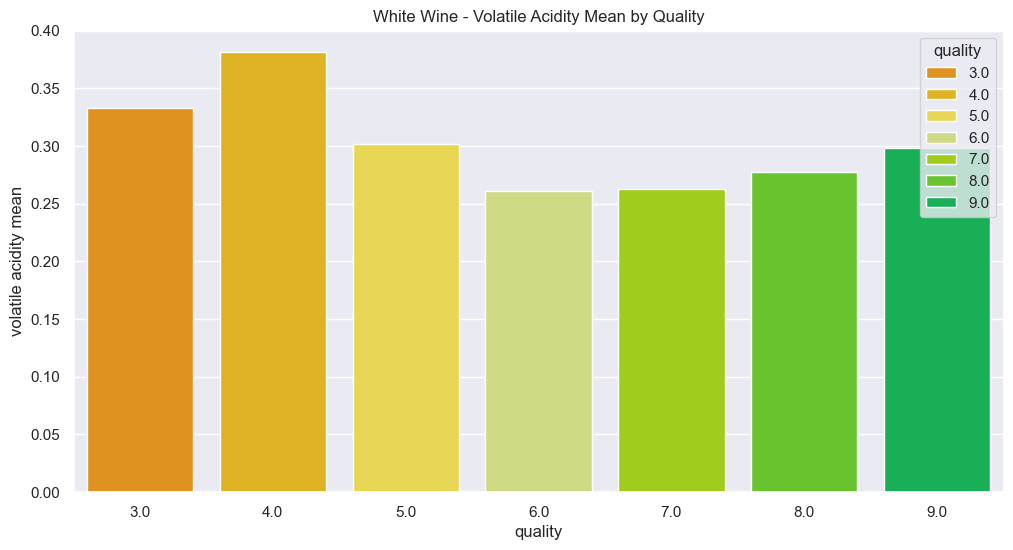

In [100]:
make_barplot(
    df=white_va_by_quality,
    x='quality',
    y='volatile acidity mean',
    title='White Wine - Volatile Acidity Mean by Quality',
    filename=PROJECT_ROOT / 'figures' / 'white' / 'volatile_acid_mean_quality'
)

In [ ]:
red_alc_by_quality = red_wine_df.group_by(
    pl.col('quality')
).agg(
    pl.col('alcohol').mean().name.suffix(' mean')
).sort(
    pl.col('quality'),
    descending=True
)
print(red_alc_by_quality)

white_alc_by_quality = white_wine_df.group_by(
    pl.col('quality')
).agg(
    pl.col('alcohol').mean().name.suffix(' mean')
).sort(
    pl.col('quality'),
    descending=True
)
print(white_alc_by_quality)

shape: (6, 2)
┌─────────┬──────────────┐
│ quality ┆ alcohol mean │
│ ---     ┆ ---          │
│ f64     ┆ f64          │
╞═════════╪══════════════╡
│ 8.0     ┆ 12.094444    │
│ 7.0     ┆ 11.465913    │
│ 6.0     ┆ 10.629519    │
│ 5.0     ┆ 9.899706     │
│ 4.0     ┆ 10.265094    │
│ 3.0     ┆ 9.955        │
└─────────┴──────────────┘
shape: (7, 2)
┌─────────┬──────────────┐
│ quality ┆ alcohol mean │
│ ---     ┆ ---          │
│ f64     ┆ f64          │
╞═════════╪══════════════╡
│ 9.0     ┆ 12.18        │
│ 8.0     ┆ 11.636       │
│ 7.0     ┆ 11.367936    │
│ 6.0     ┆ 10.575372    │
│ 5.0     ┆ 9.80884      │
│ 4.0     ┆ 10.152454    │
│ 3.0     ┆ 10.345       │
└─────────┴──────────────┘


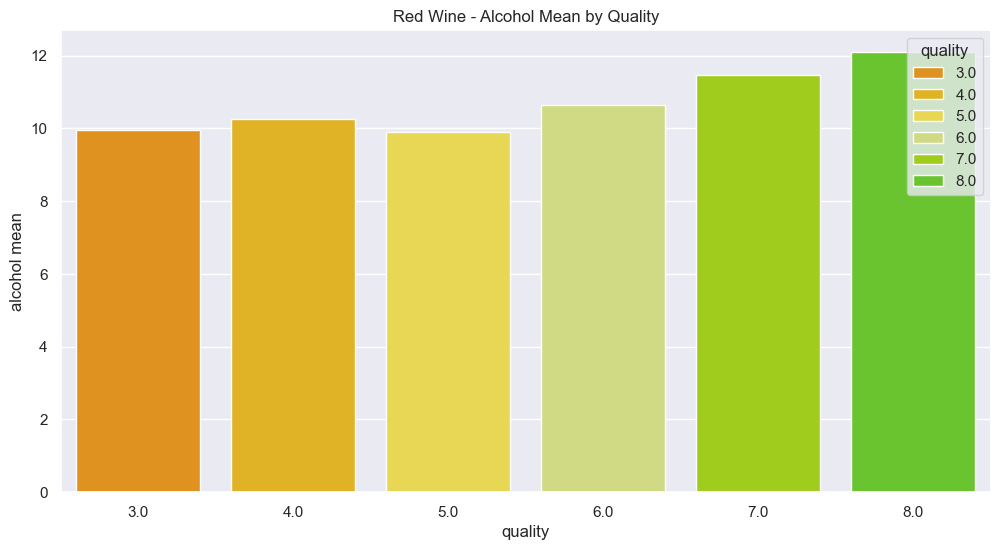

In [103]:
make_barplot(
    df=red_alc_by_quality,
    x='quality',
    y='alcohol mean',
    title='Red Wine - Alcohol Mean by Quality',
    filename=PROJECT_ROOT / 'figures' / 'red' / 'alcohol_quality'
)

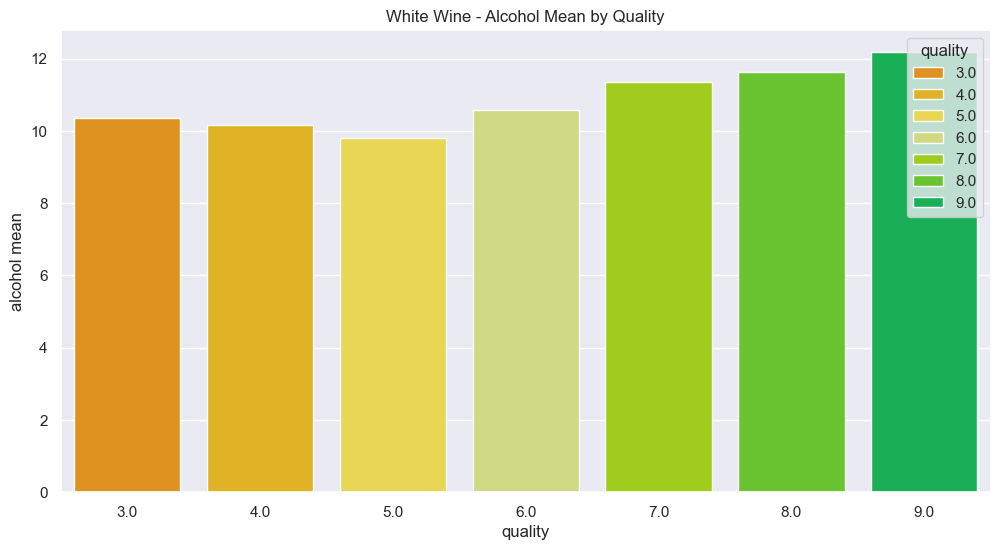

In [104]:
make_barplot(
    df=white_alc_by_quality,
    x='quality',
    y='alcohol mean',
    title='White Wine - Alcohol Mean by Quality',
    filename=PROJECT_ROOT / 'figures' / 'white' / 'alcohol_quality'
)

In [109]:
red_sul_by_quality = red_wine_df.group_by(
    pl.col('quality')
).agg(
    pl.col('sulphates').mean().name.suffix(' mean')
).sort(
    pl.col('quality'),
    descending=True
)
print(red_sul_by_quality)

shape: (6, 2)
┌─────────┬────────────────┐
│ quality ┆ sulphates mean │
│ ---     ┆ ---            │
│ f64     ┆ f64            │
╞═════════╪════════════════╡
│ 8.0     ┆ 0.767778       │
│ 7.0     ┆ 0.741256       │
│ 6.0     ┆ 0.675329       │
│ 5.0     ┆ 0.620969       │
│ 4.0     ┆ 0.596415       │
│ 3.0     ┆ 0.57           │
└─────────┴────────────────┘


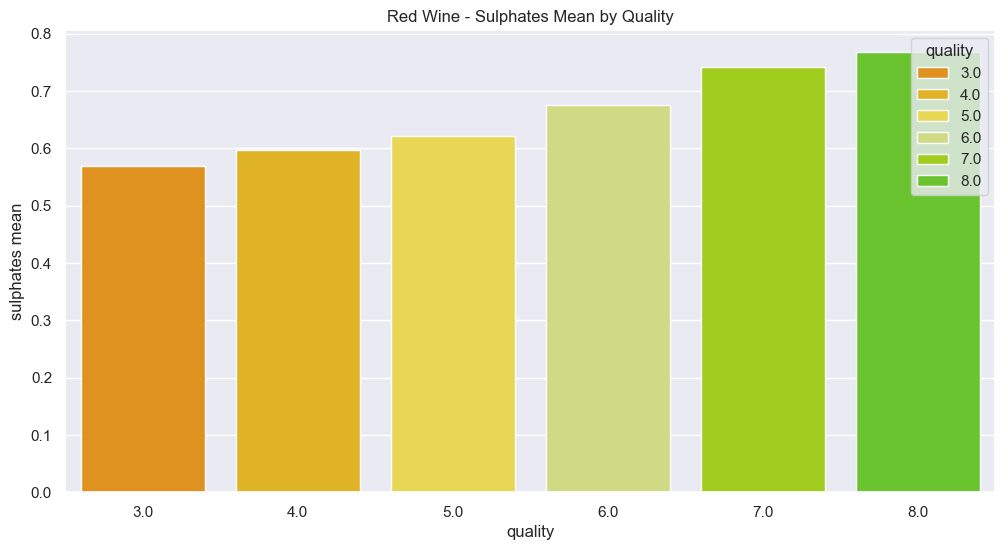

In [111]:
make_barplot(
    df=red_sul_by_quality,
    x='quality',
    y='sulphates mean',
    title='Red Wine - Sulphates Mean by Quality',
    filename=PROJECT_ROOT / 'figures' / 'red' / 'sulphates_quality'
)

In [116]:
white_chlor_by_quality = white_wine_df.group_by(
    pl.col('quality')
).agg(
    pl.col('chlorides').mean().name.suffix(' mean')
).sort(
    pl.col('quality'),
    descending=True
)
print(white_chlor_by_quality)

shape: (7, 2)
┌─────────┬────────────────┐
│ quality ┆ chlorides mean │
│ ---     ┆ ---            │
│ f64     ┆ f64            │
╞═════════╪════════════════╡
│ 9.0     ┆ 0.0274         │
│ 8.0     ┆ 0.038314       │
│ 7.0     ┆ 0.038191       │
│ 6.0     ┆ 0.045217       │
│ 5.0     ┆ 0.051546       │
│ 4.0     ┆ 0.050098       │
│ 3.0     ┆ 0.0543         │
└─────────┴────────────────┘


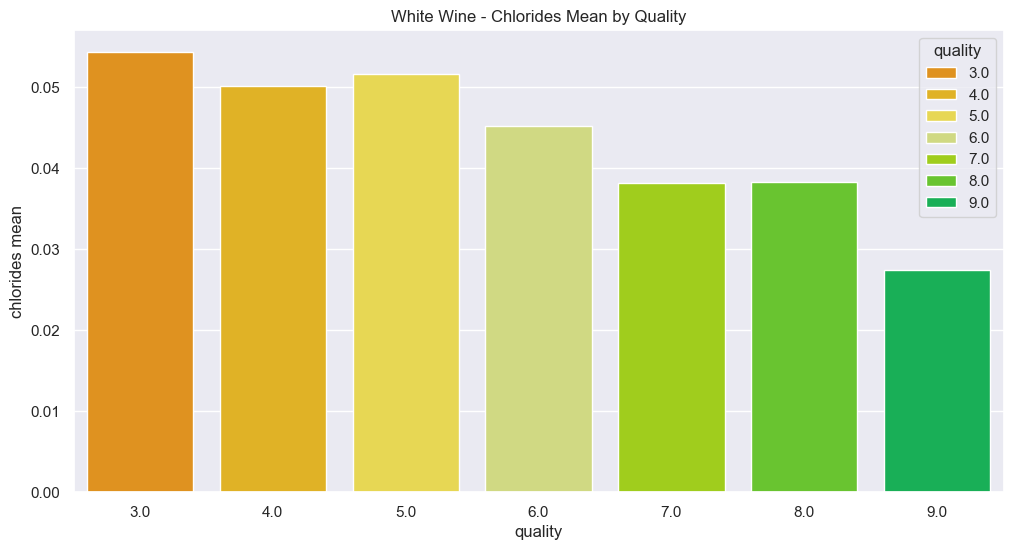

In [117]:
make_barplot(
    df=white_chlor_by_quality,
    x='quality',
    y='chlorides mean',
    title='White Wine - Chlorides Mean by Quality',
    filename=PROJECT_ROOT / 'figures' / 'white' / 'chlorides_quality'
)